In [47]:
import random
import pandas as pd
import numpy as np

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle



#-------------------------
# LOAD AND PREP THE DATA
#-------------------------
 
data_cf = pd.read_csv('fc_matrix_red200.csv')



In [52]:
print (data_cf.columns)
df = data_cf.copy()

Index(['Unnamed: 0', 'try', 'itemID', 'userID', 'rating'], dtype='object')


In [53]:
df = df.drop(columns = ['Unnamed: 0'])

# Modèle collaboratif > Hyper-paramètres

On considère ici un modèle basé sur un filtre collaboratif implicite simple. Les filtres collaboratifs sont très utilisés pour recommander des objets (films/musiques...) et prisés des grandes entreprises du numériques (youtube/deezer/amazon/netflix...). L'idée est la suivante ; premièrement, à partir des vecteurs caractéristiques des items, on peut déduire les vecteurs caractéristiques des utilisateurs. La réciproque est aussi vraie, à partir des vecteurs caractéristiques utilisateurs on peut déduire les vecteurs caractéristiques des items. Pour effectuer les calculs, on à besoin d'informations nécessairement incomplètes caractérisant l'appréciation des utilisateurs vis à vis des objets. Lorsque l'on considère des filtres collaboratifs explicites, cette information est présente sous la forme d'une note. Une note faible équivaut à un rejet de l'objet tandis que la note est d'autant plus forte que l'objet est attractif pour l'utilisateur considéré. 
Dans le cas des filtres collaboratifs implicites, cette information n'est pas claire. Le cas qui nous intéresse illustre parfaitement ce point. Ici, aucune note des utilisateurs n'est attribuée aux objets, la seule information que l'on posséde est la connaissance sur le fait que l'utilisateur ai consommé ou non tel objet. On peut bien-sur supposer que, si l'utilisateur consomme un objet cela signifie qu'il l'apprécie et à l'inverse il ne consomme pas les objets qu'il ne désire pas. On pourrait alors attribuer la note de 1 lorsque l'utilisateur consomme un objet et 0 dans le cas contraire. 
Cependant, on se rend compte aisément que cela n'est pas représentatif de la réalité. En effet, un utilisateur peut consommer un objet pour l'offrir à un ami, à l'inverse, le fait qu'il ne consomme pas certains objets ne signifie pas forcément qu'il ne les apprécie pas, il peut très bien ne pas avoir connaissance de leurs existences ou ne pas avoir un budget suffisant. 
Pour palier à ce problème, on choisit de se baser sur un modèle introduit par Yifan Hu, Yehuda Koren et Chris Volinsky qui associe à chaque prédiction un degrés de confiance. Ce degrés de confiance peut prendre en compte différentes variables en fonction du problème. Dans notre cas, on considère que, plus un utilisateur à consommé le même produit, plus on peut avoir confiance en le fait qu'il aime ce produit. La colonne "rating" comptabilise le nombre de transactions user>item identiques (0 dans le cas où aucune transaction n'a eu lieu). On pourrait aussi prendre en compte le fait que plus un produit est cher, plus l'utilisateur qui le consomme est censé l'aimer. 



In [19]:
# first, let us define some important functions 


def nonzeros(m, row):
    for index in range(m.indptr[row], m.indptr[row+1]):
        yield m.indices[index], m.data[index]
        
        

def alternating_least_squares_cg(Cui, factors, regularization=0.01, iterations=15):
    users, items = Cui.shape

    # initialize factors randomly
    X = np.random.rand(users, factors) * 0.01
    Y = np.random.rand(items, factors) * 0.01

    Cui, Ciu = Cui.tocsr(), Cui.T.tocsr()

    for iteration in range(iterations):
        least_squares_cg(Cui, X, Y, regularization)
        least_squares_cg(Ciu, Y, X, regularization)

    return (X, Y)


def least_squares_cg(Cui, X, Y, regularization, cg_steps=3):
    users, factors = X.shape
    YtY = Y.T.dot(Y) + regularization * np.eye(factors)

    for u in range(users):
        # start from previous iteration
        x = X[u]

        # calculate residual r = (YtCuPu - (YtCuY.dot(Xu), without computing YtCuY
        r = -YtY.dot(x)
        for i, confidence in nonzeros(Cui, u):
            r += (confidence - (confidence - 1) * Y[i].dot(x)) * Y[i]

        p = r.copy()
        rsold = r.dot(r)

        for it in range(cg_steps):
            # calculate Ap = YtCuYp - without actually calculating YtCuY
            Ap = YtY.dot(p)
            for i, confidence in nonzeros(Cui, u):
                Ap += (confidence - 1) * Y[i].dot(p) * Y[i]

            # standard CG update
            alpha = rsold / p.dot(Ap)
            x += alpha * p
            r -= alpha * Ap
            rsnew = r.dot(r)
            p = r + (rsnew / rsold) * p
            rsold = rsnew

        X[u] = x

# Utilité et objectifs

Comme énoncé précédemment, les filtres collaboratifs sont très utilisés pour émettre des recommandations personnalisées. Pourtant, notre problématique est différente, nous cherchons à segmenter des groupes d'utilisateurs en fonction de leurs comportements. 
Le filtre collaboratif permet de faire émerger des caractéristiques utilisateurs, à partir d'une initialisation aléatoire et par minimisation d'une fonction de coût (par méthode de descente de gradient par exemple). Ces caractéristiques doivent permettre de cibler les utilisateurs en fonction de leurs méthodes de consommation (certains préfères des produits ménagers d'autres numériques etc...) 
Une question subsiste néanmoins, comment peut on s'assurer que les vecteurs émergeant sont représentatifs des comportement utilisateurs ? On admettra que , plus les recommandations qu'ils engendrent sont pertinentes, mieux ils sont censé caractériser le consommateur. 
De ce fait, le problème de détermination des "bons" vecteurs est analogue à un problème de détermination des "meilleures" prédictions. 
Ce notebook à donc pour vocation de déterminer par validation croisée les meilleures prédictions. Une fois les hyper-paramètres sélectionnés par grille, on pourra sauvegarder les vecteurs utilisateurs correspondant. Ceux-ci seront utilisés en entrée du notebook "create_cf_model".




In [20]:
def recommend(user_id, sparse_user_item, user_vecs, item_vecs, num_items=10):
    """The same recommendation function we used before"""

    user_interactions = sparse_user_item[user_id,:].toarray()

    user_interactions = user_interactions.reshape(-1) + 1
    user_interactions[user_interactions > 1] = 0

    rec_vector = user_vecs[user_id,:].dot(item_vecs.T).toarray()

    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = user_interactions * rec_vector_scaled

    item_idx = np.argsort(recommend_vector)[::-1][:num_items]

    artists = []
    scores = []

    for idx in item_idx:
        artists.append(data.artist.loc[data.artist_id == idx].iloc[0])
        scores.append(recommend_vector[idx])

    recommendations = pd.DataFrame({'artist': artists, 'score': scores})

    return recommendations

In [21]:
def plot_value_counts(col_name,df):       
    
    values_count = pd.DataFrame(df[col_name].dropna().value_counts())    
    values_count.columns = ['count']
    
    # convert the index column into a regular column.
    values_count[col_name] = [ str(i) for i in values_count.index ]
    
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2)
    
    # change the order of the columns.
    values_count = values_count.reindex([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True)
    
    return (values_count)

# Jeux d'entrainement et jeux de test

Afin de comparer la pertinence des recommandations rigoureusement, nous devons partager nos données en divers jeux d’entraînements et de tests, nous définissons donc deux fonctions qui étudient la taille des différents folds et qui génèrent des jeux de donnés test et entraînement correspondant. 
Nous entraînerons les données sur un jeux biaisé en forçant à 0 les transactions d'une fraction du dataset original. Les prédictions seront ensuite testées sur la portion originale

In [22]:
def size_folds2(df,folds):      
    
    # study the size of last folds odd number of nb_users/folds
    
    diff = df.shape[0] - folds * np.around(df.shape[0] / folds)
    size = []
    
    for i in range (int(np.absolute(np.around(diff)))):
        
        if (diff < 0):            
            size.append(np.around(df.shape[0] / folds) - 1)
        if (diff > 0):            
            size.append(np.around(df.shape[0] / folds) + 1)
            
    for i in range (folds - (int(np.absolute(np.around(diff))))):
        
        size.append(np.around(df.shape[0] / folds)) 
    
    return (size)       

In [65]:
def traintest_split2(df,sep_init,sep_final):
    """create the train and test set"""   
    df = shuffle(df)
    testset = df.copy()
    trainset = df.copy()
       
    # define trainset
    
    # get the rating indice 
    ind_rating = df.columns.get_loc('rating')
    
    trainset.iloc[sep_init:sep_final,ind_rating][trainset.iloc[sep_init:sep_final,ind_rating]>0] = 0 
    
        
    # define testset 
    
    testset.iloc[0:sep_init,ind_rating][testset.iloc[0:sep_init,ind_rating]>0 ]= 0 
    
    testset.iloc[sep_final::,ind_rating][testset.iloc[sep_final::,ind_rating]>0] = 0 
    
    testset = shuffle(testset)
    trainset = shuffle(trainset)
    
       
    
        
    return (trainset, testset)

# Métrique d'évaluation

Une nouvelle difficulté est de déterminer une métrique d'évaluation appropriée. Nous définissons une nouvelle métrique basée sur un classement des prédictions en fonction de la probabilité de transaction estimée. Si une nouvelle transaction à lieu, on étudie le classement correspondant à la prédiction de cette dernière. Pour chaque utilisateur et pour chaque nouvelle transaction on calcule cet indicateur de telle sorte à obtenir un score en pourcentage. Si les prédictions sont aléatoires, ce score est de 50%, un score plus élevé signifie une prédiction plus mauvaise que le hasard, un score plus faible, une prédiction meilleure que le hasard. 
L'algorithme prend soin de ne pas recommander des transactions qui ont déjà eu lieu. Nous utilisons par ailleurs deux classifieurs naïfs utilisés en guise de comparaison. Le premier calcule le nombre de transactions dont chaque item fait l'objet et recommande en priorité les items les plus commandés. Le second utilise la popularité, et recommande les items les plus populaires, c'est à dire, ceux consommés par le plus grand nombre d'utilisateurs différents.


# $\sum_{i=0}^{n} \frac{u(i)}{(n)(n-i)} \left(\sum_{j=0}^{i} | u(j)-1 | \right)$

In [24]:
def penalt(u_i): 
    """define a new evaluation metric based on the rank of the recommandation mark"""
    
    #u_i = shuffle(u_i)
    rank_list = []
    
    for i in range (u_i.shape[0]):
        
        if (u_i.iloc[i] == 1):
            
            rank_list.append(i)  
    
    penalt = 0
    
    for i in range (len(rank_list)):
        
        penalt = penalt + rank_list[i] - np.count_nonzero(u_i[0:rank_list[i]])
        
    penalt = penalt / len(rank_list)
    
    # get penalt in %
    penalt = (penalt * 100) / (u_i.shape[0] - len(rank_list))
        
    return(penalt)

In [90]:
def final_model(reg_param,alpha_val,train_prelim,test_prelim):
    data = train_prelim[['userID', 'itemID', 'rating']]

    #data = data_cf[['userID', 'itemID', 'rating']]

    data = data.rename(columns={'userID':'user','itemID':'artist','rating':'plays'})
    df = data.copy()
    print (data.columns)

    # Drop NaN columns
    data = data.dropna()
    data = data.copy()

    # Create a numeric user_id and artist_id column
    data['user'] = data['user'].astype("category")
    data['artist'] = data['artist'].astype("category")
    data['user_id'] = data['user'].cat.codes
    data['artist_id'] = data['artist'].cat.codes

    # The implicit library expects data as a item-user matrix so we
    # create two matricies, one for fitting the model (item-user) 
    # and one for recommendations (user-item)
    sparse_item_user = sparse.csr_matrix((data['plays'].astype(float), (data['artist_id'], data['user_id'])))
    sparse_user_item = sparse.csr_matrix((data['plays'].astype(float), (data['user_id'], data['artist_id'])))

    # Calculate the confidence by multiplying it by our alpha value.
    alpha_val = alpha_val
    data_conf = (sparse_item_user * alpha_val).astype('double')

    # Initialize the als model and fit it using the sparse item-user matrix
    reg_param = reg_param
    X, Y = alternating_least_squares_cg(Cui=data_conf ,factors=10, regularization=reg_param, iterations=10)

    # Get the user and item vectors from our trained model
    user_vecs = sparse.csr_matrix(X)
    item_vecs = sparse.csr_matrix(Y)


    # number of users 
    users_testset = plot_value_counts(col_name='userID',df=train_prelim)
    users_testset.iloc[:,0] = pd.to_numeric(users_testset.iloc[:,0], errors='coerce').fillna(0, downcast='infer')

    # number of items 
    items_testset = plot_value_counts(col_name='itemID',df=train_prelim)
    items_testset.iloc[:,0] = pd.to_numeric(items_testset.iloc[:,0], errors='coerce').fillna(0, downcast='infer')


    nb_users = users_testset.shape[0]
    nb_items = items_testset.shape[0]
    
    # ------------------------------ COMPUTING NAIF CLASSIFIORS BASED ON TEST SET ----------------------------------

    nb_users = users_testset.shape[0]
    nb_items = items_testset.shape[0]

    # number of users 
    users_testset = plot_value_counts(col_name='userID',df=test_prelim)
    users_testset.iloc[:,0] = pd.to_numeric(users_testset.iloc[:,0], errors='coerce').fillna(0, downcast='infer')

    # number of items 
    items_testset = plot_value_counts(col_name='itemID',df=test_prelim)
    items_testset.iloc[:,0] = pd.to_numeric(items_testset.iloc[:,0], errors='coerce').fillna(0, downcast='infer')


    # order items_testset by items and save in numpy arrays
    items_testset = items_testset.sort_values(by='itemID', ascending=False)
    npusers_items = np.matrix(items_testset.iloc[:,:])  
    
    
    # --------------------------------------------------------------------------------------------------

    # init scores 
    score = 0 
    

    nb_users = users_testset.shape[0]
    nb_items = items_testset.shape[0]

    # number of transactions
    divid = nb_users        

    # ------------------------------------ EVALUATING PERFORMENCE  --------------------------------------

    # Create recommendations for all users in the testset

    for ind_user in range (nb_users):

        user_id = users_testset.iloc[ind_user,0]

              
        recommendations = recommend(user_id, sparse_user_item, user_vecs, item_vecs, num_items=nb_items)            

        # order recommendations by items        
        recommendations = recommendations.sort_values(by='artist', ascending=False)   

        # find the "true" rating array of items for user "ind_user"         
        item_matrix = test_prelim[test_prelim.loc[:,'userID'] == users_testset.iloc[ind_user,0]]

        sum_mat = np.sum(item_matrix.loc[:,'rating'])

        # cases with transactions
        if (sum_mat > 0):

            # order item_matrix by items                
            item_matrix = item_matrix.sort_values(by='itemID', ascending=False)
            npusers_matrix = np.matrix(item_matrix.iloc[:,0::])


            # add the "true" rating array of items for user "ind_user" 
            recommendations['rui'] = npusers_matrix[:,3]

            # add the naif classif 1 and 2 
            
            recommendations = recommendations[recommendations.loc[:,'rui']>(-1)]
                 
            recommendations.loc[:,'rui'][recommendations.loc[:,'rui'] > 0] = 1

            # --------------------- Perform on predicted score --------------            
            # order item by predicted score
            recommendations = recommendations.sort_values(by='score', ascending=False)

            # calculate penalties 
            penalties = penalt(u_i=recommendations.iloc[:,2])
            score = score + penalties


        # cases without any transaction
        if (sum_mat == 0): 
            

            divid = divid - 1

    # compute scores 
    print ('scoreTOT')
    print (score/divid)
    

    score = score / divid
    
    
    return(score)


In [88]:
def final_model_tot(df,folds,reg_param,alpha_val):
    
    # generate the size of our different folds 
    
    ind_rating = df.columns.get_loc('rating')
    
    
    size = size_folds2(df=df,folds=folds) 
    
       
    
    # init total scores

    score_tot = 0
    
    for k in range (len(size)): 
                
        # ------------------------------------ SHARING DATASET (TRAIN/TEST) --------------------------------------
        # computer our train set and test set 
        train_set, test_set = traintest_split2(df=df,sep_init=int(np.sum(size[0:k])),sep_final=int(np.sum(size[0:k])+size[k]))
        
        test_prelim = test_set.copy()
        train_prelim = train_set.copy()
        # number of users 
        users_testset = plot_value_counts(col_name='userID',df=test_prelim)
        users_testset.iloc[:,0] = pd.to_numeric(users_testset.iloc[:,0], errors='coerce').fillna(0, downcast='infer')


        # number of items 
        items_testset = plot_value_counts(col_name='itemID',df=test_prelim)
        items_testset.iloc[:,0] = pd.to_numeric(items_testset.iloc[:,0], errors='coerce').fillna(0, downcast='infer')

        nb_users = users_testset.shape[0]
        nb_items = items_testset.shape[0]

        for ind_user in range (nb_users):
            #print (ind_user)

            item_matrix = test_prelim[test_prelim.loc[:,'userID'] == users_testset.iloc[ind_user,0]]
            item_matrix_tr = train_prelim[train_prelim.loc[:,'userID'] == users_testset.iloc[ind_user,0]] 

            item_matrix = item_matrix.sort_values(by='itemID', ascending=False)
            item_matrix_tr =item_matrix_tr.sort_values(by='itemID', ascending=False)


            for i in range (item_matrix_tr.shape[0]):  

                if (item_matrix.iloc[i,3]>0):

                    if (item_matrix_tr.iloc[i,3]>0):
                        
                        item_matrix.iloc[i,3] = -1                        
        

            if (ind_user==0):
                test_prelim2 = item_matrix

            if (ind_user!=0):

                test_prelim2  = pd.concat([test_prelim2, item_matrix],axis=0)
        
        test_prelim = test_prelim2.copy()
        
        score = final_model(reg_param=reg_param,alpha_val=alpha_val,train_prelim=train_prelim,test_prelim=test_prelim)
        score_tot = score_tot + score
        
    score_tot = score_tot/folds
    
    return(score_tot)
    
    

# Validation croisée sur grille

Nous implémentons maintenant une validation croisée sur les deux hyperparamètres rentrant en jeux. A savoir, le paramètre de régularisation de la fonction de coût et, un facteur intervenant dans la formule mathématique du degrés de confiance.

In [92]:
folds = 5
reg_params = np.array([0.01, 0.1, 10, 100])
alpha_params = np.array([1,20,40,60,80])    
    
    
param_matrix = np.zeros((reg_params.shape[0],alpha_params.shape[0]))
    
for alpha in range (alpha_params.shape[0]):
        
    for reg in range (reg_params.shape[0]):
            
        alpha_val = alpha_params[alpha]
            
        reg_param = reg_params[reg]
            
        # run the model 
        score_tot = final_model_tot(df=df,folds=folds,reg_param=reg_param,alpha_val=alpha_val)          
        
        # save information 
        param_matrix[reg,alpha] = score_tot
            
            
   

Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT
34.57515435717691
Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT
35.049282116688765
Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT
34.626838319932965
Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT
35.32596392193347
Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT
35.73429673496461
Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT
35.36262874881979
Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT
35.85123860646169
Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT
35.43116841307803
Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT
35.44366280552263
Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT
34.405820488854054
Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT
30.552323543951925
Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT
30.71304370240945
Index(['user', 'artist', 'plays'], dtype='object')
scoreTOT


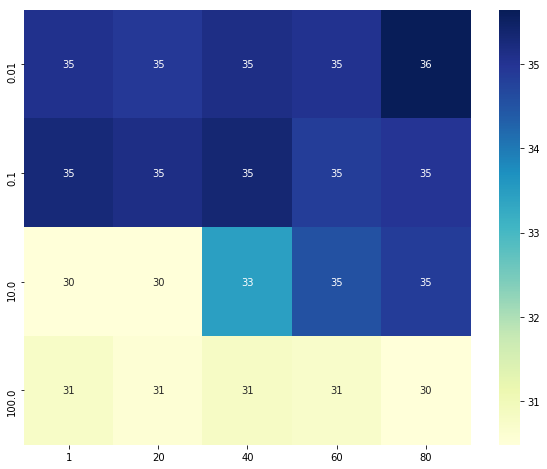

In [109]:
import matplotlib.pyplot as plt 
import seaborn as sns
#d = {'cluster_num':cluster_num[:],'cluster_annot':cluster_annot[:]}
param = pd.DataFrame(data=param_matrix)

d = {"1":[35.062307, 35.298904,  30.486874 , 30.765991
],'20':[34.924442,  35.144684 , 30.497121,  30.569950
],'40':[35.155448,  35.353653,  33.455774,  30.809678
],'60':[35.054359,  34.840266, 34.538744,  30.734896
],'80':[35.644285,  34.997493,  34.869041, 30.480826]
}

param = pd.DataFrame(data=d)
# visualiser la validation croisée sous la forme d'une heatmap
param = param.rename({0:0.01 ,1:0.1, 2:10, 3:100}, axis='index')

f, (ax1) = plt.subplots(1, 1, figsize=(10, 8), sharex=True)

sns.heatmap(data=param, annot=True,cmap="YlGnBu")